In [198]:
import numpy as np
import math
import matplotlib.pyplot as plt

from collections import Counter

In [199]:
class Branch():
    
    def __init__(self,depth):
        self.left = None
        self.right = None
        self.depth = depth
    
    def split(self,X,y):
        # find best split
        self.criterion = find_best_split(X,y)
        # generate left branch data
        self.Xle = X[X[:,self.criterion[0]]<=self.criterion[1]]
        self.yle = y[X[:,self.criterion[0]]<=self.criterion[1]]
        # generate right branch data
        self.Xgt = X[X[:,self.criterion[0]]>self.criterion[1]]
        self.ygt = y[X[:,self.criterion[0]]>self.criterion[1]]
        
        # max depth reached
        if (self.depth==0):
            return
        else:
            # check if a left branch needs further splitting:
            if gini(self.yle>0):
                self.left = Branch(self.depth-1)
                self.left.split(self.Xle,self.yle)
            # check if right branch needs further splitting:
            if gini(self.ygt>0):
                self.right = Branch(self.depth-1)
                self.right.split(self.Xgt,self.ygt)
    
    def get_label(self,x):
        # compare to criterion
        if (x[self.criterion[0]]<=self.criterion[1]):
            if (self.left is None):
                return Counter(self.yle).most_common(1)[0][0]
            else:
                return self.left.get_label(x)
        else:
            if (self.right is None):
                return Counter(self.ygt).most_common(1)[0][0]
            else:
                return self.right.get_label(x)

In [200]:
class DecisionTree():
    
    def __init__(self,max_depth):
        self.max_depth = max_depth

    def fit(self,X,y):
        self.head = Branch(self.max_depth)
        self.head.split(X,y)
        
    def predict(self,X):
        y = np.zeros(len(X))
        i = 0
        for x in X:
            c = self.head.get_label(x)
            y[i] = c
            i+=1
        return y

In [201]:
size = 300
r = 6
# blob 1
x = np.random.normal(4,2,(size))
y = np.random.normal(1,2,(size))
# blob 2
x2 = np.zeros(size)
y2 = np.zeros(size)
for i in range(size):
    x2[i] = 4+r*math.cos(2*math.pi*(i/size))# + 
    y2[i] = 1+r*math.sin(2*math.pi*(i/size))# + 
x2+=np.random.normal(0,1.5,(size))
y2+=np.random.normal(0,1.5,(size))

x = np.concatenate((x,x2))
y = np.concatenate((y,y2))
# add xy together, add intercept 
X = np.hstack((np.ones(2*size),x,y)).reshape(3,2*size).T
# reuse y for flags
y[:size] = 1
y[size:] = -1

In [202]:
# data
s = size//2
# test set
# blob 1
tx = np.random.normal(4,1.5,s)
ty = np.random.normal(1,1.5,s)
# blob 2
tx2 = np.zeros(s)
ty2 = np.zeros(s)
for i in range(s):
    tx2[i] = 4+r*math.cos(2*math.pi*(i/s))# + 
    ty2[i] = 1+r*math.sin(2*math.pi*(i/s))# + 
tx2+=np.random.normal(0,1,s)
ty2+=np.random.normal(0,1,s)

tx = np.concatenate((tx,tx2))
ty = np.concatenate((ty,ty2))
# add xy together, add intercept 
tX = np.hstack((np.ones(size),tx,ty)).reshape(3,size).T
# reuse y for flags
ty[:s] = 1
ty[s:] = -1

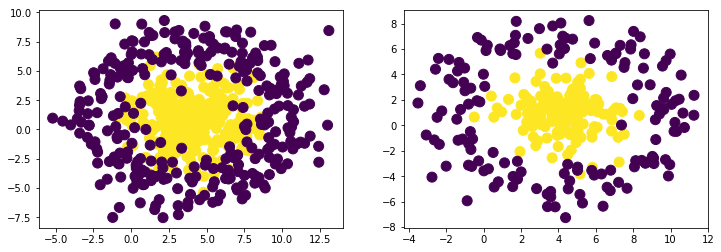

In [203]:
fig, axes = plt.subplots(ncols=2,figsize=(12,4))
axes[0].scatter(X[:,1],X[:,2],c=y,s=100)
axes[1].scatter(tX[:,1],tX[:,2],c=ty,s=100)
plt.show()

In [230]:
mine = DecisionTree(15)

In [231]:
mine.fit(X,y)

In [232]:
pred = mine.predict(tX)
(pred==ty).mean()

0.91

In [205]:
pred = clf.predict(tX)
(pred==ty).mean()

0.92

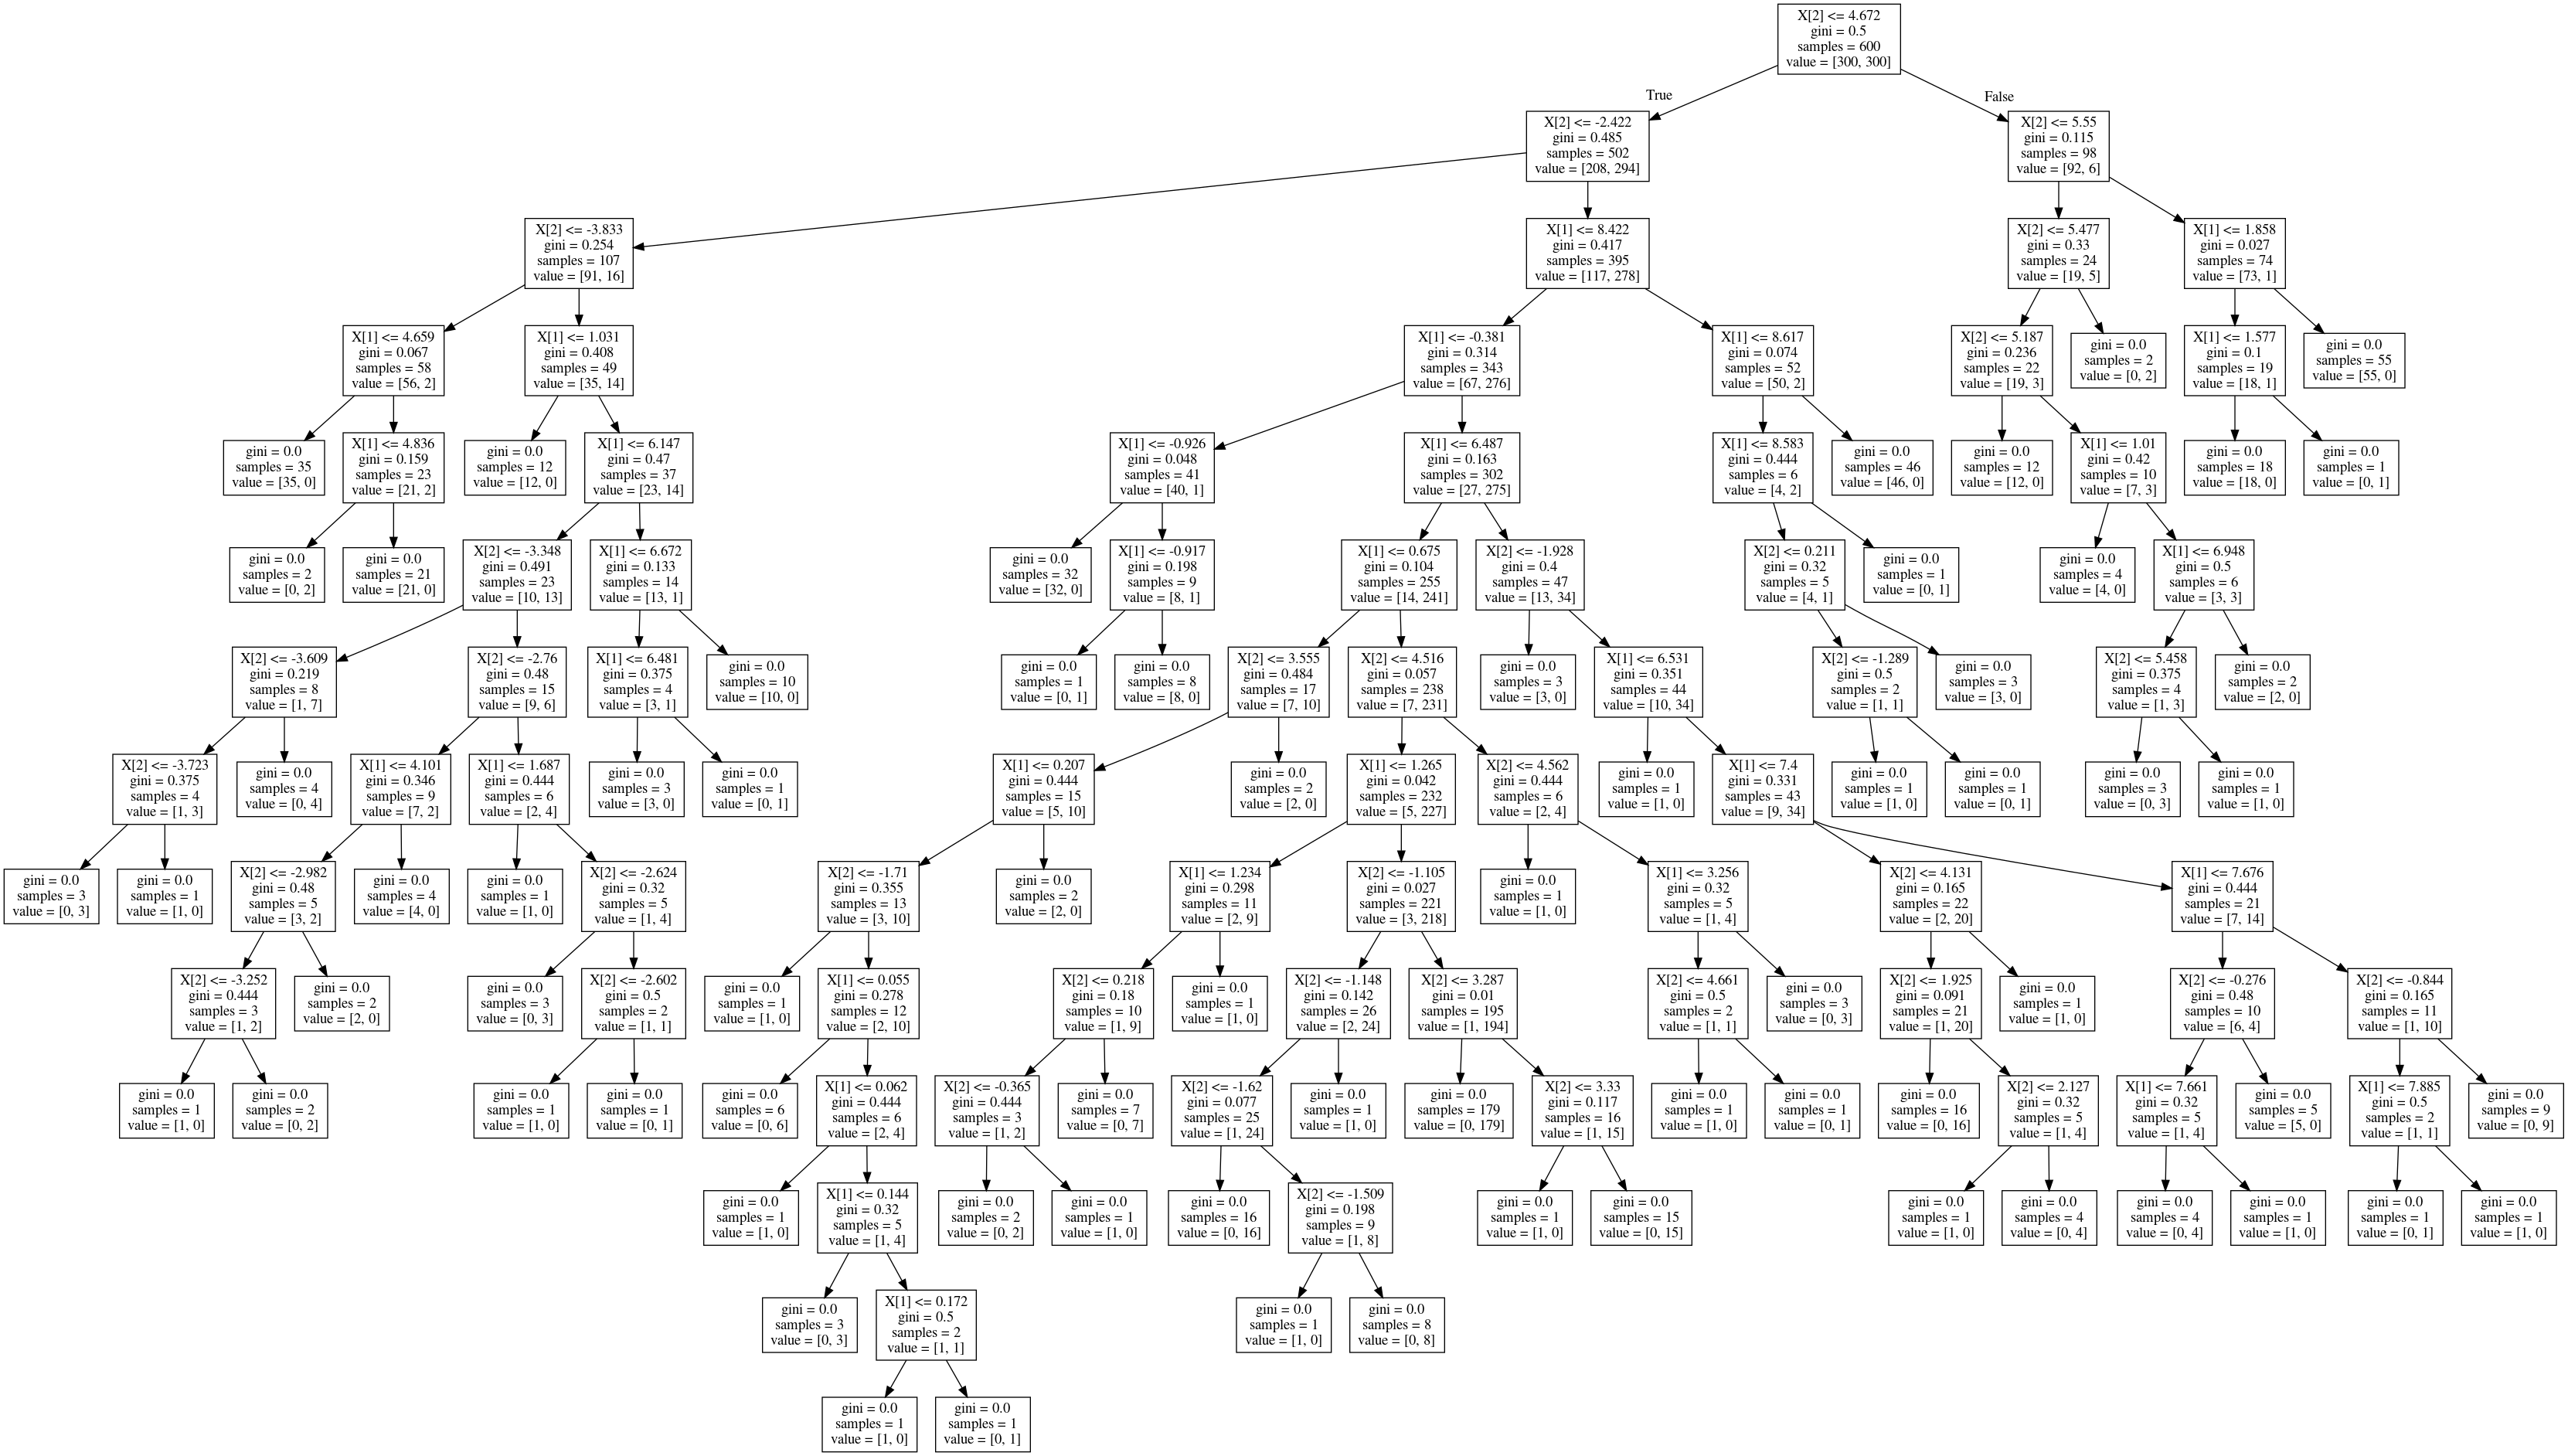

In [204]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(X,y)
# visualize tree
from IPython.display import Image  
from sklearn.externals.six import StringIO  
import pydotplus

dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

In [53]:
def gini(y):
    """
    Calculate and return the gini index of the given array of labels
    """
    uniques,counts = np.unique(y,return_counts=True)
    return 1-((counts/len(y))**2).sum()

In [229]:
def find_best_split(X,y,min_group_size=2):
    """
    Finds the best split in X in terms of lowest gini index in y after the split
    """
    # best (column, <=value, gini)
    # starting values
    best = (0,0,1)
    n_total = len(X)
    for c in range(X.shape[1]):
        for x in X[:,c]:
            # try a split
            mask = X[:,c]<=x
            count = mask.sum()
            # weighted gini score
            g = gini(y[mask])*(count/n_total) + gini(y[mask==False])*((n_total-count)/n_total)
            if (g<best[2] and len(y[X[:,c]<=x])>=min_group_size and len(y[X[:,c]>x])>=min_group_size):
                best = (c,x,g)
    return best